## Discrete Optimization #1 - Djibouti

__[Traveling Salesman Problem](http://www.math.uwaterloo.ca/tsp/world/countries.html)__ - 38 cities (Djibouti)

find the shortest path, so you visit all cities without visiting the same twice.

In [212]:
import tsplib95
import numpy as np
from timeit import default_timer as timer
from scipy.spatial.distance import squareform
import random
import string
from deap import base, creator, tools
import matplotlib.pyplot as plt

In [213]:
Djibouti = tsplib95.load('dj38.tsp')

In [214]:
Djibouti.as_name_dict()

{'name': 'dj38',
 'comment': 'requesting data sets without duplications.',
 'type': 'TSP',
 'dimension': 38,
 'edge_weight_type': 'EUC_2D',
 'node_coords': {1: [11003.6111, 42102.5],
  2: [11108.6111, 42373.8889],
  3: [11133.3333, 42885.8333],
  4: [11155.8333, 42712.5],
  5: [11183.3333, 42933.3333],
  6: [11297.5, 42853.3333],
  7: [11310.2778, 42929.4444],
  8: [11416.6667, 42983.3333],
  9: [11423.8889, 43000.2778],
  10: [11438.3333, 42057.2222],
  11: [11461.1111, 43252.7778],
  12: [11485.5556, 43187.2222],
  13: [11503.0556, 42855.2778],
  14: [11511.3889, 42106.3889],
  15: [11522.2222, 42841.9444],
  16: [11569.4444, 43136.6667],
  17: [11583.3333, 43150.0],
  18: [11595.0, 43148.0556],
  19: [11600.0, 43150.0],
  20: [11690.5556, 42686.6667],
  21: [11715.8333, 41836.1111],
  22: [11751.1111, 42814.4444],
  23: [11770.2778, 42651.9444],
  24: [11785.2778, 42884.4444],
  25: [11822.7778, 42673.6111],
  26: [11846.9444, 42660.5556],
  27: [11963.0556, 43290.5556],
  28: [1197

In [215]:
def calculate_edge_weights(tsproblem): 
    N = tsproblem.dimension
    edges_list = []
    for x in range(1, N+1): 
        for y in range(x+1, N+1):
            current_weight = tsproblem.get_weight(x, y)
            edges_list.append(current_weight)

    return edges_list

In [216]:
def calculate_distance_matrix(tsproblem): 
    N = tsproblem.dimension
    edges_list = []
    for x in range(1, N+1): 
        current_point = []
        for y in range(x+1, N+1):
            current_weight = tsproblem.get_weight(x, y)
            current_point.append(current_weight)
        edges_list.append(current_point)
            
    edges = squareform(np.hstack(edges_list)) # complete distances matrix
    return edges

In [217]:
calculate_distance_matrix(Djibouti)

array([[   0.,  291.,  794., ..., 1852., 1625., 1858.],
       [ 291.,    0.,  513., ..., 1599., 1413., 1649.],
       [ 794.,  513.,    0., ..., 1331., 1288., 1514.],
       ...,
       [1852., 1599., 1331., ...,    0.,  441.,  444.],
       [1625., 1413., 1288., ...,  441.,    0.,  236.],
       [1858., 1649., 1514., ...,  444.,  236.,    0.]])

In [218]:
## DEAP Genetic Algorithm

In [219]:
class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [220]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [221]:
## globals,

random.seed(11);
np.random.seed(121);


INDIVIDUAL_SIZE = NUMBER_OF_CITIES = 38 # N
POPULATION_SIZE = 76 # N * 2
N_ITERATIONS = 570 # N * 15 (see notes)
N_MATINGS = 38 # N (everyone mates)

## city indexes
cities = list(Djibouti.get_nodes())

## distances calculated 
distances = calculate_distance_matrix(Djibouti)

In [222]:
## Min.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)

## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [223]:
def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation

toolbox.register("evaluate", EVALUATE)

In [224]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.03) # mutation rate higher as we have small population (see notes)
toolbox.register("select", tools.selTournament, tournsize=30) # selection tournament size determined by experiment (see notes)

In [225]:
start = timer()
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)
stats, population = a.Run()
end = timer()
elapsed_time = end - start

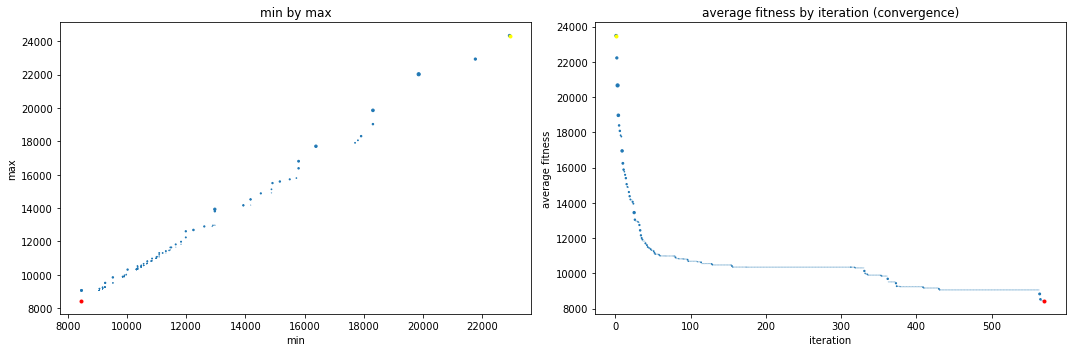

In [226]:
## create plots

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')

_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])

_ = plt.title('average fitness by iteration (convergence)')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average fitness')

_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

In [229]:
## results 

fitnesses = sorted([ 
    (i, toolbox.evaluate(individual)) 
    for i, individual in enumerate(population) 
], key=lambda x: x[1])
best_individual = tools.selBest(population, k=1)[0]

print('RESULTS')
print('Best individual (path): ', best_individual)
print('Fitness of the best individual: ', EVALUATE(best_individual))
print('Convergence (top 5 individuals): ', fitnesses[:5])
print('Computation time (seconds): ', elapsed_time)

RESULTS
Best individual (path):  [16, 10, 11, 7, 5, 3, 2, 4, 6, 14, 24, 25, 22, 19, 1, 0, 9, 13, 20, 28, 29, 31, 34, 32, 33, 35, 37, 36, 27, 23, 21, 12, 8, 15, 17, 18, 26, 30]
Fitness of the best individual:  8461.0
Convergence (top 5 individuals):  [(0, 8461.0), (1, 8461.0), (2, 8461.0), (3, 8461.0), (4, 8461.0)]
Computation time (seconds):  6.5139971999997215


## Conclusion 

*The chosen algorithm*

I implemented the Genetic Algorithm for TSP in this case as the algorithm is easy to understand, allowing for more ability to experiment with the parameters than other algorithms. As the population and individual sizes are relatively small, the time cost of the implementation is essentially the same as other algorithms (though it has been noted that Simmulated Annealing is more efficient to solve large TSP problems than GA implementation), which had me prioritize the implementation which would allow for experimentation and parameter selection easily with the DEAP library.

*The parameters of the algorithm*

- Fitness - each individual is evaluated as the sum of the distances between each city, in the order of the individual's chromosome (see EVALUATE function)
- Mate - used __[DEAP cxOrdered](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered)__, as we cannot drop any cities and the order of the cities matter to get the most from the parent's fitness increases over time. 
- Mutate - used __[DEAP mutShuffleIndexes](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes)__, with probablity 3%. Mutation rate was increased as small population benefits from increased mutation (see Notes). Tournament size was determined to be best at 30, at a small price of increased time cost.

*The final results, both solution and fitness, computational time, and convergence curve can be seen above*



*The number of function evaluations or stopping criterion*

The number of iterations was determined by experimentation (see Notes). For N number of cities, in this case 38, N * 15 iterations gave similar answers to N * 20, but decreased the time cost. At the same time, this was more accurate than the original implementation of N * 10 iterations as it had a smaller result. Hence N * 15 = 570 iterations was selected.


## Notes 

__[TSBLIP95](https://tsplib95.readthedocs.io/en/stable/pages/usage.html#rendering-problems)__

__[DEAP](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes)__

__[Genetic Algorithm: The Travelling Salesman Problem via Python, DEAP](https://medium.com/@pasdan/genetic-algorithm-the-travelling-salesman-problem-via-python-deap-f238e0dd1a73)__

__[Solving the TSP with GAs](https://notebook.community/40423140/123456/content/notebook/Solving%20the%20TSP%20with%20GAs)__

__[Analysis of the impact of parameters values on the Genetic Algorithm for TSP, Conclusion](https://www.researchgate.net/publication/261135110_Analysis_of_the_impact_of_parameters_values_on_the_Genetic_Algorithm_for_TSP)__
- More  efforts need  to  be spent  in  finding  *correct  population  sizing  estimates  for particular problems*. 
- Considering  the effect  of changing  the  initial population size for  fixed mutation rate, we  see that  the *effect of  the mutation is important for small initial populations*, since it contributes  to  promoting  new  solutions  in  the  solution space.
Note increased mutation probability form 1% (deafult) to 3% 

**Iteration tests**

For POPULATION_SIZE = 76 (N * 2) and N_MATINGS = 38 (N, everyone mates), mutation rate of 3%, I had the following results: 
190 (N * 5) = 9534,
380 (N * 10) = 8502 (starting point),
570 (N * 15) = 8493,
780 (N * 20) = 8493,
indicating an optimal point of accuracy and speed at N * 15, 570. Additional experiments could be implemented to test further accuracy, with the averages of multiple experiments at the same iteration value to increase accuracy.

**Tournament size tests**

For POPULATION_SIZE = 76 (N * 2) and N_MATINGS = 38 (N, everyone mates), ITERATIONS = 570, mutation rate of 3%, I had the following results: 
10 = 9113 (starting point),
20 = 9333,
30 = 8329.
indicating an optimal point at more tournament participants, 30. Note this did increase the time cost of the function, so may need to be reduced for larger problems. 
